In [2]:
#%reset -f
%matplotlib inline
import math as mt
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from numba import jit

<font size = 6> FitzHugh-Nagumo Model 1

<font size = 5> $\frac{\partial u}{\partial t} = \epsilon \cdot (v - \alpha u) + D_{u} \cdot \nabla^{2}u$

<font size = 5> $\frac{\partial v}{\partial t} = -u + \mu v - v^{3} + D_{v} \cdot \nabla^{2}v$ 

<font size = 5> Null Flux Boundary Conditions </font>

In [20]:
class parameters:
  def __init__(self,a,mu,e,du,dv,size_partition,T,L):
    self.a = a
    self.mu = mu
    self.e = e
    self.du = du
    self.dv = dv
    self.size_partition = size_partition
    self.T = T
    self.L = L
      
  def values(self):
    dx = self.L / self.size_partition  # paso espacial
    dt = 1*10**(-3)  # paso tiempo
    n = int(self.T / dt)  # numero de iteraciones
    return self.a,self.mu,self.e,self.du,self.dv,self.size_partition,self.T,self.L,dx,dt,n

  def initial_conditions(self):
    U = np.random.rand(self.size_partition, self.size_partition)
    V = np.random.rand(self.size_partition, self.size_partition)
    return U,V
      
#Finite Difference 2D:

#Laplacian
@jit(nopython=True)
def laplacian(Z, dx):
    Z_lap = np.zeros_like(Z)
    for i in range(1, Z.shape[0] - 1):
        for j in range(1, Z.shape[1] - 1):
            Z_lap[i, j] = (Z[i-1, j] + Z[i+1, j] + Z[i, j-1] + Z[i, j+1] - 4 * Z[i, j]) / dx**2
    return Z_lap

#main
@jit(nopython=True)
def main_null_flux(n, a, mu, e, du, dv, dt, U, V):
    for i in range(n):
        # laplacian for U and V
        delta_U = laplacian(U, dx)
        delta_V = laplacian(V, dx)
        Uc = U[1:-1, 1:-1]
        Vc = V[1:-1, 1:-1]
        # Mesh change
        U[1:-1, 1:-1] = Uc + dt * (du * delta_U[1:-1, 1:-1] + e*(Vc - a * Uc))
        V[1:-1, 1:-1] = Vc + dt * (dv * delta_V[1:-1, 1:-1] - Uc + mu*Vc - Vc**3)
        
        # Null Flux
        for Z in (U, V):
            Z[0, :] = Z[1, :] 
            Z[-1, :] = Z[-2, :]
            Z[:, 0] = Z[:, 1]
            Z[:, -1] = Z[:, -2]
            
        if i == n - 1:
            return U

#Map
def generate_map(matrix,L,P):
    vmin = np.min(matrix)
    vmax = np.max(matrix)
    fig, ax = plt.subplots()
    ax.imshow(matrix[1:P+2,1:P+2], cmap = 'viridis',interpolation='spline36',extent=[0, L, 0, L],vmin=vmin, vmax=vmax)
    ax.set_axis_off()

FITZH = parameters(0.92, 0.71, 4.23,0.05,0.00028,100,400,2) #a,mu,e,du,dv,size_partition,T,L

a,mu,e,du,dv,size_partition,T,L,dx,dt,n= FITZH.values()

U,V = FITZH.initial_conditions()

result = main_null_flux(n, a, mu, e, du, dv, dt, U, V)

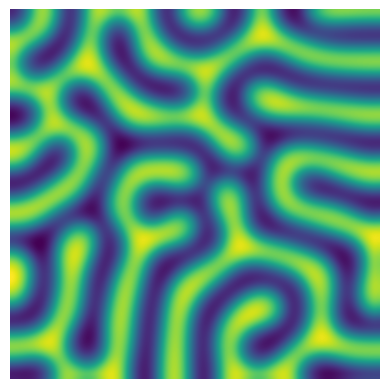

In [21]:
generate_map(result,L,size_partition)

<font size = 5> Periodic Boundary Conditions </font>

In [22]:
class parameters:
  def __init__(self,a,mu,e,du,dv,size_partition,T,L):
    self.a = a
    self.mu = mu
    self.e = e
    self.du = du
    self.dv = dv
    self.size_partition = size_partition
    self.T = T
    self.L = L
      
  def values(self):
    dx = self.L / self.size_partition  # paso espacial
    dt = 1*10**(-3)  # paso tiempo
    n = int(self.T / dt)  # numero de iteraciones
    return self.a,self.mu,self.e,self.du,self.dv,self.size_partition,self.T,self.L,dx,dt,n

  def initial_conditions(self):
    U = np.random.rand(self.size_partition, self.size_partition)
    V = np.random.rand(self.size_partition, self.size_partition)
    return U,V
      
#Finite Difference 2D:

#Laplacian
@jit(nopython=True)
def laplacian(Z, dx):
    Z_lap = np.zeros_like(Z)
    for i in range(1, Z.shape[0] - 1):
        for j in range(1, Z.shape[1] - 1):
            Z_lap[i, j] = (Z[i-1, j] + Z[i+1, j] + Z[i, j-1] + Z[i, j+1] - 4 * Z[i, j]) / dx**2
    return Z_lap

#main
@jit(nopython=True)
def main_null_flux(n, a, mu, e, du, dv, dt, U, V):
    for i in range(n):
        # laplacian for U and V
        delta_U = laplacian(U, dx)
        delta_V = laplacian(V, dx)
        Uc = U[1:-1, 1:-1]
        Vc = V[1:-1, 1:-1]
        # Mesh change
        U[1:-1, 1:-1] = Uc + dt * (du * delta_U[1:-1, 1:-1] + e*(Vc - a * Uc))
        V[1:-1, 1:-1] = Vc + dt * (dv * delta_V[1:-1, 1:-1] - Uc + mu*Vc - Vc**3)
        
        # Periodic boundary conditions   
        for Z in (U, V):
            Z[:, 0] = Z[:, -3] 
            Z[:, -1] = Z[:, 2]
            Z[0, :] = Z[-3, :]
            Z[-1, :] = Z[2, :]
            Z[1, :] = Z[-2, :]
            Z[:, 1] = Z[:, -2]
            
        if i == n - 1:
            return U

#Map
def generate_map(matrix,L,P):
    vmin = np.min(matrix)
    vmax = np.max(matrix)
    fig, ax = plt.subplots()
    ax.imshow(matrix[1:P+2,1:P+2], cmap = 'viridis',interpolation='spline36',extent=[0, L, 0, L],vmin=vmin, vmax=vmax)
    ax.set_axis_off()

FITZH = parameters(0.92, 0.71, 4.23,0.05,0.00028,100,400,2) #a,mu,e,du,dv,size_partition,T,L

a,mu,e,du,dv,size_partition,T,L,dx,dt,n= FITZH.values()

U,V = FITZH.initial_conditions()

result = main_null_flux(n, a, mu, e, du, dv, dt, U, V)

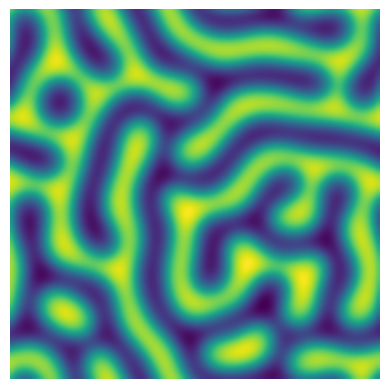

In [23]:
generate_map(result,L,size_partition)